In [1]:
__version__ = '2021-06-26'
__authors__ = ['Robert Nikutta <robert.nikutta@gmail.com>', 'Enrique Lopez-Rodriguez', 'Kohei Ichikawa']

# Hypercat - Morphology
This notebook shows how the `morphology` module in HYPERCAT can be used to investigate morphological quantities of the HYPERCAT brightness maps an the projected dust cloud maps.

## Disclaimer and Attribution
HYPERCAT / CLUMPY models and the accompanyin software were published in two papers. If you decide to make use of either the models, the software, the example notebooks, or the included pupil images of telescopes included with HYPERCAT, please cite these two papers:

* **Nikutta, Lopez-Rodriguez, Ichikawa, Levenson, Packham, Hönig, Alonso-Herrero, "Hypercubes of AGN Tori (Hypercat) -- I. Models and Image Morphology", ApJ (2021, accepted)**

* **Nikutta, Lopez-Rodriguez, Ichikawa, Levenson, Packham, Hönig, Alonso-Herrero, "Hypercubes of AGN Tori (Hypercat) -- II. Resolving the
torus with Extremely Large Telescopes", ApJ (2021, under review)**


## Table of contents
* [Imports & setup](#import)
* [Morphology on 2D Gaussians](#gaussians)
  * [Image centroid](#centroid)
  * [Image rotation](#rotation)
  * [Measuring the size of emission features](#size)
  * [Measuring elongation](#elongation)
  * [Half-light radius](#rhl)
  * [Gini coefficient](#gini)
* [Further information](#furtherinfo)

<a class="anchor" id="import"></a>
## Imports and setup

In [2]:
# std lib
import warnings
#warnings.filterwarnings("ignore", message="dataset.value has been deprecated")

# 3rd party
import numpy as np
from astropy import units as u 
from astropy.io import fits
import pylab as plt
import matplotlib

# own
import hypercat as hc
from hypercat import morphology
from hypercat import plotting
from hypercat import imageops
print("HYPERCAT version:",hc.__version__)

HYPERCAT version: 0.1.5


<a class="anchor" id="gaussians"></a>
## Morphology on 2D Gaussians

We begin by demonstrating some morphological operations on 2D Gaussians, where the concepts can be made clear easily. In the notebook https://github.com/rnikutta/hypercat/tree/master/examples/05-hypercat-morphology-clumpy.ipynb we will then apply the same functions to HYPERCAT/CLUMPY model images.

<a class="anchor" id="centroid"></a>
### Image centroid

Let's start with making a 2D Gaussian, elongated in the x-direction by a factor 2:1, centered on the image center. The image is 101x101 pixels in size.

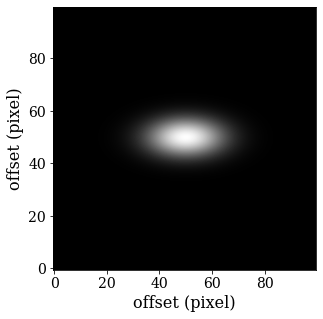

In [3]:
g = morphology.gaussian(npix=100,sx=10,sy=5)  # sigma_x = 14 pixels, sigma_y = 7 pixels
plotting.multiplot(g,cmaps='gray',colorbars=None,panelsize=5);

We can measure certain properties from the image alone, using linear algebra and image moments, for instance find the centroid (in pixel locations (x,y)):

In [4]:
M00, x, y = morphology.get_centroid(g)
print("Centroid location (in pixels (x,y)):", x, y)

Centroid location (in pixels (x,y)): 49.99999256639806 50.0


Given that the image is 101x101 pixels in size, and that counting starts with zero in Python, (x,y) = (50,50) corresponds to the central pixel.<br>
We can see that the centroid will be also found correctly when our Gaussian is de-centered in the image frame:

Centroid location in pixels: (x,y) = (60.00,20.00):


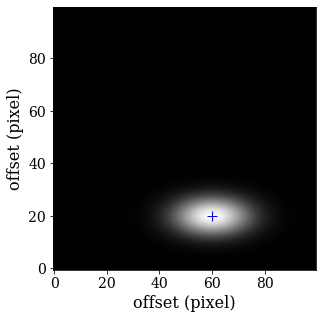

In [5]:
g = morphology.gaussian(npix=100,sx=10,sy=5,x0=10,y0=-30)
fig, axes = plotting.multiplot(g,cmaps='gray',colorbars=None,panelsize=5);
ax = axes[0][0]
M00, xc, yc = morphology.get_centroid(g)  # returns: zero-order moment, xcentroid, ycentroid
ax.plot(xc,yc,'b+',ms=10)
print("Centroid location in pixels: (x,y) = (%.2f,%.2f):" % (xc, yc))

The centroid is found at (x,y) = (60,20), which correponds to 10 pixels to the right of the center in the x-direction, and 30 pixels (50-30=20) below the center in y-direction. The (0,0) pixel is in the lower-bottom corner in the image above.

<a class="anchor" id="rotation"></a>
### Image rotation

HYPERCAT's `morphology` module also has functions to measure the rotation of the dominant emission feature in an image:

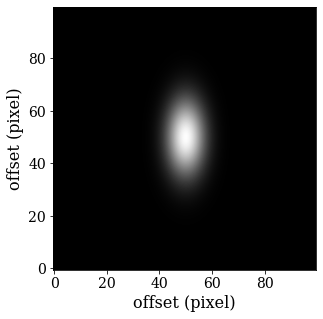

In [6]:
g = morphology.gaussian(npix=100,sx=5,sy=10,theta=0)  # theta = 0 --> 0 degrees rotation; angles measured from North, counter-clockwise
plotting.multiplot(g,cmaps='gray',colorbars=None,panelsize=5);

In [7]:
print("Position angle: %g degrees" % morphology.get_angle(g))

Position angle: 0 degrees


And if we rotate the Gaussian by various angles:

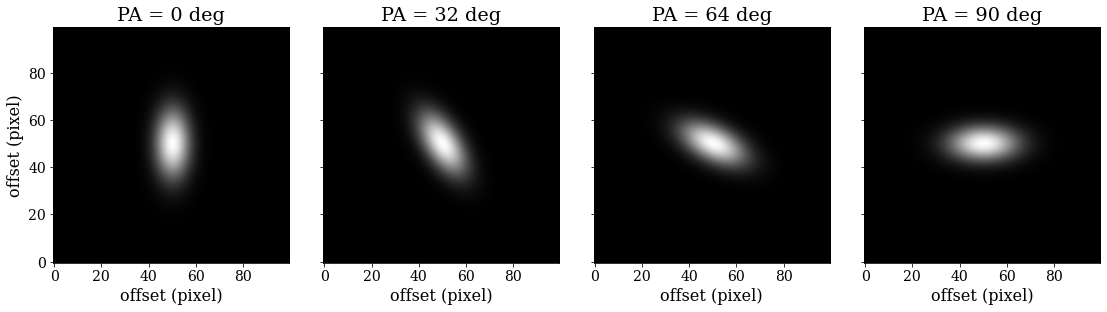

In [8]:
gaussians = [morphology.gaussian(npix=100,sx=5,sy=10,theta=theta) for theta in (0,32,64,90)]
position_angles = ["PA = %g deg" % morphology.get_angle(g) for g in gaussians]
plotting.multiplot(gaussians,cmaps='gray',colorbars=None,panelsize=4,titles=position_angles);

If we rotate the other way, i.e. clock-wise, the angles will still be measured from North through East, i.e. counter-clockwise:

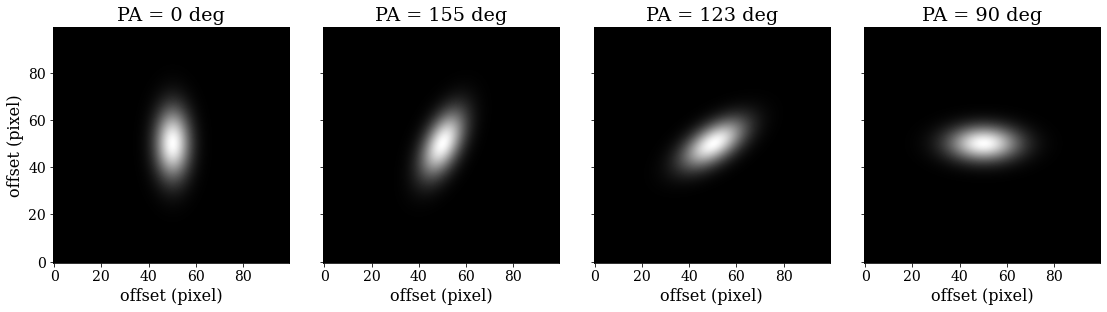

In [9]:
gaussians = [morphology.gaussian(npix=100,sx=5,sy=10,theta=theta) for theta in (0,-25,-57,-90)]
position_angles = ["PA = %g deg" % morphology.get_angle(g) for g in gaussians]
plotting.multiplot(gaussians,cmaps='gray',colorbars=None,panelsize=4,titles=position_angles);

That is, subtract 180 from the measured angles to recover the originally given angle. (for symmetric sources the equivalent angles 0=180 and 90=-90 are sometimes measured).

Note that finding the PA that way also works for de-centered sources:

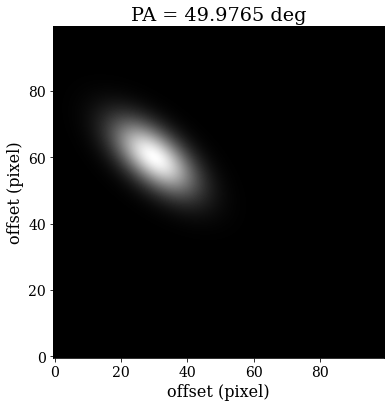

In [10]:
g = morphology.gaussian(npix=100,sx=5,sy=10,x0=-20,y0=10,theta=50)
plotting.multiplot(g,cmaps='gray',colorbars=None,panelsize=6,titles="PA = %g deg" % morphology.get_angle(g));

Images can be easily combined. Note however that morphological measurements consider the entire distribution of pixels in the image:

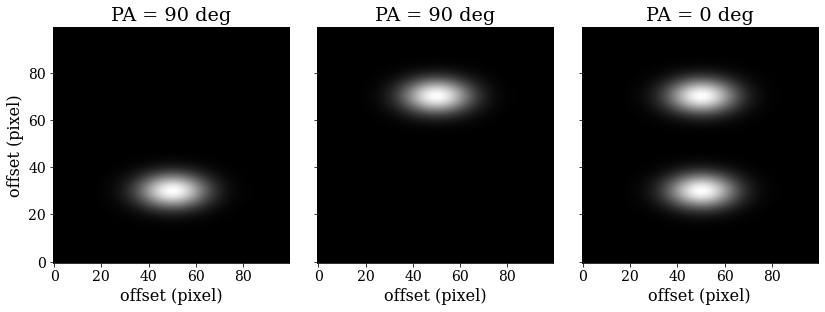

In [11]:
g1 = morphology.gaussian(npix=100,sx=5,sy=10,y0=-20,theta=90) # shifted down
g2 = morphology.gaussian(npix=100,sx=5,sy=10,y0=20,theta=90) # shifted up
g = g1+g2 # combined
titles = ["PA = %g deg" % morphology.get_angle(_) for _ in (g1,g2,g)]
plotting.multiplot((g1,g2,g),cmaps='gray',colorbars=None,panelsize=4,titles=titles);

The last panel with two Gaussians combined, is elongsted

<a class="anchor" id="size"></a>
### Measuring the size of emission features
Using image moments we can measure the sizes of an emission feature (here our 2D Gaussians) in each direction x,y independently. The so-called radius of gyration about an axis is the distance to a line parallel to the axis, at which all the “mass” (i.e. all the pixel values) could be concentrated without changing the second moment about that axis. HYPERCAT measures the gyration radii about the x and y axes, rgx and rgy.

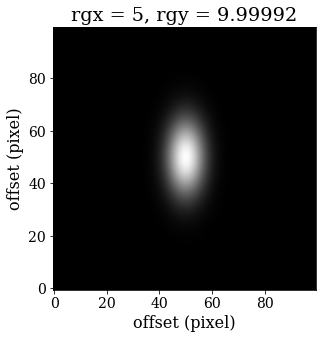

In [12]:
g = morphology.gaussian(npix=100,sx=5,sy=10,theta=0)
rgx, rgy = morphology.get_rgyr(g)
plotting.multiplot(g,cmaps='gray',colorbars=None,panelsize=5,titles="rgx = %g, rgy = %g" % (rgx,rgy));

For 2D Gaussians, the radii of gyration correspond to the sigma values of the Gaussians. The radii or gyration are applicable generally however, not only to Gaussians.

The radii of gyration can be considered the semimajor and seminor axes of an ellipse, anchored on the image centroid:

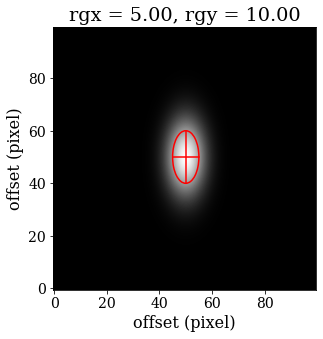

In [13]:
fig, axes = plotting.multiplot(g,cmaps='gray',colorbars=None,panelsize=5,titles="rgx = %.2f, rgy = %.2f" % (rgx,rgy));
ax = axes[0][0]

# gyration radii & ellipse
M00, xc, yc = morphology.get_centroid(g)  # 0-order moment, xcentroid, ycentroid

# plot the ellipse axes
ax.plot((xc-rgx,xc+rgx),(yc,yc),ls='-',color='#ff0000',lw=1.5)
ax.plot((xc,xc),(yc-rgy,yc+rgy),ls='-',color='#ff0000',lw=1.5)

# plot the ellipse
arc = matplotlib.patches.Arc((xc,yc), 2*rgx, 2*rgy, angle=0.0, theta1=0.0, theta2=360.0, zorder=2,\
                              edgecolor='#ff0000', ls='-', lw=1.5)
ax.add_artist(arc);

<a class="anchor" id="elongation"></a>
### Measuring elongation
Since w know the x and y sizes independently, computing the elongtion (aspect ratio) is of easy. HYPERCAT provides a convenience function as well:

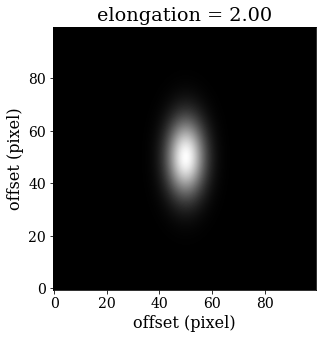

In [14]:
g = morphology.gaussian(npix=100,sx=5,sy=10,theta=0)
plotting.multiplot(g,cmaps='gray',colorbars=None,panelsize=5,titles="elongation = %.2f" % morphology.get_elongation(g));

Let's measure elongation for a 2D Gaussian rotated at different angles:

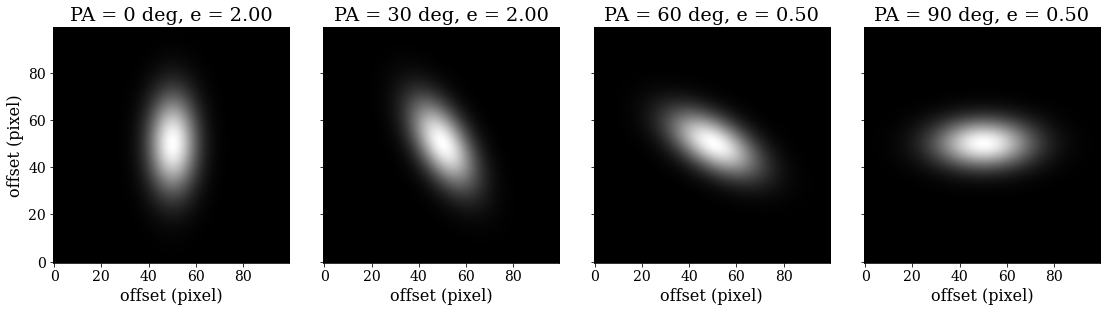

In [15]:
thetas = (0,30,60,90)  # PAs in degrees, N through E (counter-clockwise)
gaussians = [morphology.gaussian(npix=100,sx=7,sy=14,theta=theta) for theta in thetas]
titles = ["PA = %g deg, e = %.2f" % (thetas[j],morphology.get_elongation(gaussians[j])) for j in range(len(gaussians))]
plotting.multiplot(gaussians,cmaps='gray',colorbars=None,panelsize=4,titles=titles);

The elongation is independet of the position angle. When the PA is such that the bulk of the emission is more aligned with one axis, the ratio y/x switches, i.e. an elongation 2:1 is measured as 1:2.

<a class="anchor" id="rhl"></a>
### Half-light radius
A popular measure of morphological size is the half-light radius, R_HL, and HYPERCAT can compute it. However, R_HL can not measure size independently in two directions, and is sensitive to where the radius as anchored (e.g. image center, centroid pixel, or peak pixel).

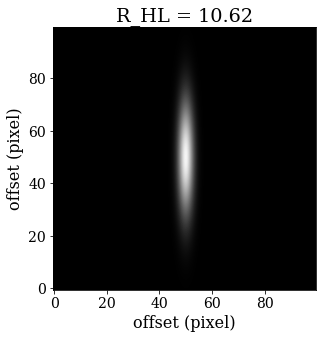

In [16]:
g = morphology.gaussian(npix=100,sx=2,sy=15)
rhl = morphology.halflight_radius(g,center='origin')

title = "R_HL = %.2f" % rhl
plotting.multiplot(g,cmaps='gray',colorbars=None,panelsize=5,titles=title);

<a class="anchor" id="gini"></a>
### Gini coefficient
The Gini coefficient measures the level of inequality in a distribution (here, of pixel values). It takes values between 0 and 1.

Let's compute the Gini coefficient G for a number of cases: a uniform aquare, a random aquare, three sizes of a 2D circular Gaussian, and a delta function (single non-zero pixel).

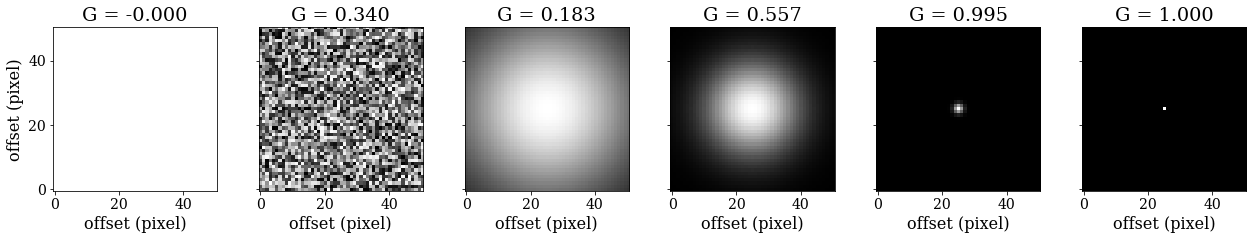

In [17]:
npix = 51

# make various images
delta = np.zeros((npix,npix))
delta[npix//2,npix//2] = 0.7  # a single pixel is non-zero

images = [
    np.ones((npix,npix)),  # image full of ones
    np.random.rand(*(npix,npix)), # image with random pixel values
    morphology.gaussian(npix,sx=20,sy=20), # large circular Gaussian
    morphology.gaussian(npix,sx=10,sy=10), # medium circular Gaussian
    morphology.gaussian(npix,sx=1,sy=1), # very small circular Gaussian
    delta
]

# for easier plotting, normalize all images to range = (0,1)
images = [img/img.max() for img in images]

titles = ["G = %.3f" % morphology.gini(_) for _ in images]
plotting.multiplot(images,cmaps='gray',colorbars=None,panelsize=3,titles=titles,
                   interpolation=None,norm=matplotlib.colors.Normalize(vmin=0,vmax=1));

The results confirm that:
- The closer to uniform the distribution of image pixels is, the more G approaches zero.
- A single non-zero pixel in an image produces G = 1.
- A random distribution of pixel values has G = 1/3.

The Gini coefficient is a good and simple proxy for "compactness" or "concentration" of a morphology, if there is only one or a few major components contributing.

<a class="anchor" id="furtherinfo"></a>
## Further information
* To learn how HYPERCAT's morphological functions can be applied to CLUMPY images of AGN tori, please see this notebook: https://github.com/rnikutta/hypercat/tree/master/examples/05-hypercat-morphology-clumpy.ipynb
* For a demonstration of other capabilities of HYPERCAT, please check out the various other notebooks in: https://github.com/rnikutta/hypercat/tree/master/examples/